In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

from beam import Cantilever, MATERIALS

In [186]:
N = 1000
    
all_res = []

# TODO: is uniform sampling reasonable? Or from a logarithmic scale?
for i in range(N):
    h = random.uniform(10, 500)
    tw = random.uniform(1.5, 10)
    blf = random.uniform(1, 100)
    tlf = random.uniform(1, 12)
    buf = random.uniform(1, 100)
    tuf = random.uniform(1, 12)
    F = random.uniform(-100000, 100000)
    L = random.uniform(500, 3000)
    matname = random.choice(list(MATERIALS.keys()))

    if (buf >= tw) and (blf >= tw) and (buf+blf < h/2) and (L > 3*h):
        params = {'L': L, 'h': h, 'tw': tw, 'blf': blf, 
                  'tlf': tlf, 'buf': buf, 'tuf': tuf, 'F': F, 'matname': matname}
        beam = Cantilever(matname, L, h, tw, blf, tlf, buf, tuf) 
        res = beam.analyse_single(F)  
        res.update(params)
        all_res.append(res)

In [187]:
# some values are nan (probably because of strange geometry), drop them
df = pd.DataFrame(all_res).dropna()
len(df)

408

In [188]:
# separate features and targets
feature_cols = ['L', 'h', 'tw', 'blf', 'tlf', 'buf', 'tuf', 'matname', 'F']
target_cols = ['wmax', 'rf_t_uf', 'rf_t_lf', 'rf_c_uf', 'rf_c_lf', 'rf_lb_uf',
               'rf_lb_lf', 'rf_s_web', 'rf_wb', 'rf_lat', 'mass', 'cost']

dfx = df[feature_cols]
dfy = df[target_cols]


In [189]:
dfy.describe()

,wmax,rf_t_uf,rf_t_lf,rf_c_uf,rf_c_lf,rf_lb_uf,rf_lb_lf,rf_s_web,rf_wb,rf_lat,mass,cost
count,408.000000,408.000000,408.000000,408.000000,408.000000,4.080000e+02,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000
mean,74.265945,inf,inf,inf,inf,inf,inf,49.818235,21.152237,15.135858,17.059010,9743.787326
std,1128.695422,NaN,NaN,NaN,NaN,NaN,NaN,303.333234,207.404161,151.502071,11.345764,14624.568218
min,-1902.966877,0.067181,0.017778,0.017603,0.056077,1.799006e-02,0.015864,0.572562,0.010234,0.016945,1.404815,79.581525
25%,-45.371905,1.266015,1.075570,1.006811,1.076617,9.631748e+00,10.489781,3.993528,0.326765,0.463594,8.253065,1274.549850
50%,0.169043,inf,243.934742,216.993059,inf,1.173918e+04,inf,8.003604,1.222281,1.196647,14.432699,2636.391503
75%,50.926302,inf,inf,inf,inf,inf,inf,15.599019,3.391044,3.376154,22.883621,12971.087947
max,20920.575703,inf,inf,inf,inf,inf,inf,4534.129284,3217.214426,2939.793736,67.283332,70236.704627


In [190]:
#which ones have infinite RF?
rffinite = (df.filter(regex="^rf_") < np.inf).astype(int)

In [191]:
# train/test split
# feature scaling
# one-hot encoding of matname
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures, PowerTransformer, FunctionTransformer
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

In [192]:
X_train, X_test, y_train, y_test, yc_train, yc_test = train_test_split(dfx, dfy, rffinite, random_state=0)
X_train

,L,h,tw,blf,tlf,buf,tuf,matname,F
150,2775.614846,336.111014,7.995751,63.794468,9.263692,76.319233,5.476635,AL7010,38584.792050
264,1933.366985,216.578493,7.503601,23.406483,11.682845,64.094030,9.544503,AL2198,-44664.261293
218,2678.902892,236.326282,9.925558,48.888075,3.476953,16.508950,4.556220,AL2198,-12175.870977
311,1227.266982,370.493113,9.143747,47.524355,1.138326,37.510926,5.398022,TI64,65535.425068
235,1234.941295,241.135985,1.935401,63.646668,5.416795,13.108818,11.383266,AL2198,-83115.341320
...,...,...,...,...,...,...,...,...,...
323,1760.928610,454.400328,3.477315,78.309432,7.447489,30.137817,8.727186,AL7010,62801.072154
192,1664.344261,466.173224,8.274102,76.451354,11.405847,18.029109,8.442626,TI64,-16666.179776
117,1705.418685,374.475602,4.666163,81.324211,5.650076,80.137433,11.482028,AL2198,-9448.000034
47,1544.622392,293.625468,3.213383,26.497283,1.715219,16.413212,8.074326,AL7010,-10657.782623


## Plan

- feature tranformer bauen
  - one hot für material
  - F: abs, +/-
- targets: diese können inf werden (menge A)
  - rf_t_uf
  - rf_t_lf
  - rf_c_uf
  - rf_c_lf
  - rf_lb_uf
  - rf_lb_lf 	
- targets: werden nicht inf (menge B)?
  - rf_s_web
  - rf_wb
  - rf_lat
- neue targets bauen: inf ja/nein
- klassifizierer für menge A bauen
- target transformieren
  - w: abs, +/-


### Classification if RF is infinite

- a simple decision tree classifier works; it finds that F is the only relevant feature.
- I love it.

In [193]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer

# preprocessing mit sklearn: Mist, because I don't know which material was used
# L, h, tw, blf, tlf, buf, tuf, mat_1, mat_2, F, F_sign

linear_model_preprocessor = ColumnTransformer(
    [
        ("log_geom", Pipeline([('log', FunctionTransformer(np.log, check_inverse=False)),
                               ('scal', MinMaxScaler())
                              ]), ["L", "h", "tw", "blf", "tlf", "buf", "tuf"]),
        ("onehot_matname", OneHotEncoder(drop="first"), ["matname"]),
        ("log_f", Pipeline([('log', FunctionTransformer(lambda x: np.log(np.abs(x)), check_inverse=False)),
                           ('scal', MinMaxScaler())
                           ]), ["F"]),
        ("sign_f", FunctionTransformer(lambda x: x >= 0), ["F"]),
    ], 
    remainder="drop",
)


In [194]:
clf = Pipeline([
    ('prep', linear_model_preprocessor),
    ('dt', DecisionTreeClassifier(max_depth=1)),
])

In [195]:
clf = clf.fit(X_train, yc_train)
#for feature_name, val in zip(X_train.columns, clf.feature_importances_):
#    print(feature_name, val)

In [196]:
clf.score(X_test, yc_test)

1.0

In [197]:
clf.predict(X_train[:10])

array([[0, 1, 1, 0, 1, 0, 1, 1, 1],
       [1, 0, 0, 1, 0, 1, 1, 1, 1],
       [1, 0, 0, 1, 0, 1, 1, 1, 1],
       [0, 1, 1, 0, 1, 0, 1, 1, 1],
       [1, 0, 0, 1, 0, 1, 1, 1, 1],
       [0, 1, 1, 0, 1, 0, 1, 1, 1],
       [0, 1, 1, 0, 1, 0, 1, 1, 1],
       [0, 1, 1, 0, 1, 0, 1, 1, 1],
       [0, 1, 1, 0, 1, 0, 1, 1, 1],
       [1, 0, 0, 1, 0, 1, 1, 1, 1]])

In [198]:
yc_train.describe()

,rf_t_uf,rf_t_lf,rf_c_uf,rf_c_lf,rf_lb_uf,rf_lb_lf,rf_s_web,rf_wb,rf_lat
count,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.0,306.0,306.0
mean,0.506536,0.493464,0.493464,0.506536,0.493464,0.506536,1.0,1.0,1.0
std,0.500776,0.500776,0.500776,0.500776,0.500776,0.500776,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0
50%,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.0,1.0,1.0
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0


## Regression

- log transform of features and targets makes sense because the targets are mostly 
  a product of the features. 
- we do not need much regulatisation, because the data are from a deterministic model.

In [199]:
# Group A: will not be inf
targets_a = ['mass', 'cost']
# Group B: will not be inf, but needs to be multiplied by sign
targets_b = ['wmax']
# Group C: may be inf
targets_c = ['rf_t_uf', 'rf_t_lf', 'rf_c_uf', 'rf_c_lf', 'rf_lb_uf',
             'rf_lb_lf', 'rf_s_web', 'rf_wb', 'rf_lat']

In [200]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import Matern

### Mass

0.9915199943039715


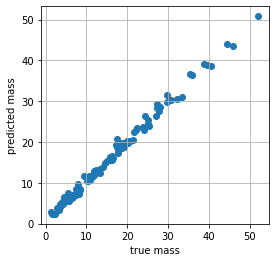

In [201]:
# Mass
features_m = ['L', 'h', 'tw', 'blf', 'tlf', 'buf', 'tuf', 'matname']
target_m = 'mass'

prep_geo = ColumnTransformer(
    [
        ("scal", MinMaxScaler(), ["L", "h", "tw", "blf", "tlf", "buf", "tuf"]),
        ("onehot_matname", OneHotEncoder(drop="first"), ["matname"]),
    ], 
    remainder="drop",
)

# few examples: Lasso + PolynomialFeatures
# more examples: SVR
rmass = Pipeline([
    ('prep', prep_geo),
    ("poly", PolynomialFeatures(interaction_only=True)),
    #('regr', Lasso(alpha=0.01))
    ('regr', SVR(C=100))
    #('regr', GaussianProcessRegressor())
])

rmass = rmass.fit(X_train, y_train[target_m]) #.values.ravel())
ypred = rmass.predict(X_test)

print(r2_score(ypred, y_test[target_m]))

fig, ax = plt.subplots()
ax.scatter(y_test[target_m], ypred);

ax.grid();
ax.set_aspect('equal')
ax.set_xlabel("true mass")
ax.set_ylabel("predicted mass");

### Cost

0.9179433342698111


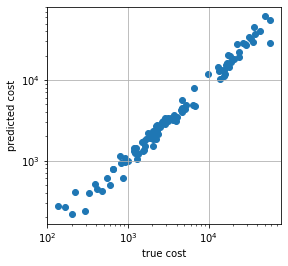

In [202]:
features_c = ['L', 'h', 'tw', 'blf', 'tlf', 'buf', 'tuf', 'matname']
target_c = 'cost'

prep_cost = ColumnTransformer(
    [
        #("scal", MinMaxScaler(), ["L", "h", "tw", "blf", "tlf", "buf", "tuf"]),
        ("onehot_matname", OneHotEncoder(drop="first"), ["matname"]),
    ], 
    remainder="passthrough",
)
# few examples: Lasso + PolynomialFeatures
# more examples: SVR
rcost = Pipeline([
    ('prep', prep_cost),
    #('poly', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('scal', MinMaxScaler()),
    #('regr', TransformedTargetRegressor(Lasso(alpha=0.01), func=np.log, inverse_func=np.exp)),
    ('regr', TransformedTargetRegressor(SVR(C=100, epsilon=.1), func=np.log, inverse_func=np.exp)),
    #('regr', GaussianProcessRegressor())
])

rcost = rcost.fit(X_train, y_train[target_c]) #.values.ravel())
ypred = rcost.predict(X_test)

print(r2_score(ypred, y_test[target_c]))

fig, ax = plt.subplots()
ax.scatter(y_test[target_c], ypred);

ax.grid();
ax.set_aspect('equal')
ax.set_xlabel("true cost")
ax.set_ylabel("predicted cost");
ax.semilogx()
ax.semilogy();

### rf_lb_lf

In [246]:
def train_rf(X, y, finite_threshold=1e4):
    finite = y < finite_threshold 

    #base = GaussianProcessRegressor(kernel=Matern())
    base = SVR(C=10, epsilon=0.1, kernel='rbf')
    #base = regressor=Ridge()

    regr = Pipeline([
        ('pre', linear_model_preprocessor),
        ('reg', TransformedTargetRegressor(regressor=base, 
                                           func=np.log, 
                                           inverse_func=np.exp, 
                                           check_inverse=False))
        #('reg', base)
    ])
    return regr.fit(X[finite], y[finite])
    

In [259]:
def plot_rf(reg, X, y, finite_threshold=1e4):

    finite = y < finite_threshold 
    # we should do scoring based on log values...
    ypred = reg.predict(X[finite])
    print(reg.score(X[finite], y[finite]))
    fig, ax = plt.subplots()
    ax.scatter(y[finite], ypred);
    ax.semilogx()
    ax.semilogy();
    ax.grid();
    ax.set_aspect('equal')

0.3645108929373939


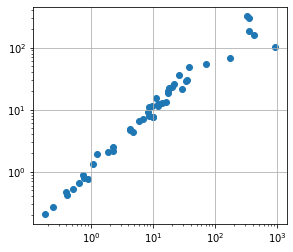

In [260]:
reg_lb_lf = train_rf(X_train, y_train['rf_lb_lf'])
plot_rf(reg_lb_lf, X_test, y_test['rf_lb_lf'])

0.6368696143093502


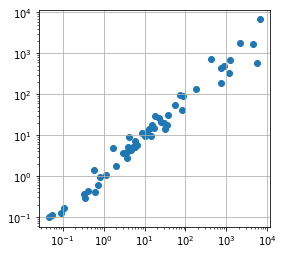

In [261]:
### lb_uf
reg_lb_uf = train_rf(X_train, y_train['rf_lb_uf'])
plot_rf(reg_lb_uf, X_test, y_test['rf_lb_uf'])

0.15808576295270937


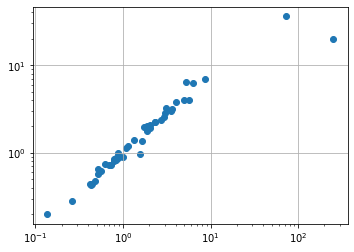

In [266]:
### t_uf
reg_t_uf = train_rf(X_train, y_train['rf_t_uf'])
plot_rf(reg_t_uf, X_test, y_test['rf_t_uf'])

0.9566266107528478


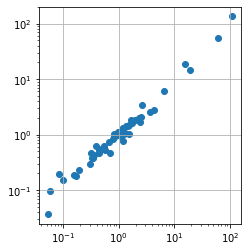

In [265]:
### c_uf
reg_c_uf = train_rf(X_train, y_train['rf_c_uf'])
plot_rf(reg_c_uf, X_test, y_test['rf_c_uf'])

0.1339022843942529


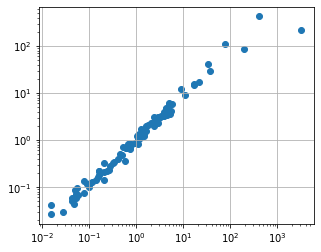

In [267]:
### lb_web
reg_wb = train_rf(X_train, y_train['rf_wb'])
plot_rf(reg_wb, X_test, y_test['rf_wb'])